# Forensic POS Data Analysis

$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

### Backgound & Objective
In the summer of 2006, a Canadian company claimed that it went out of buisness.  Over a two year period prior to this claim, a group of Americans had been investing in this company.  The Canadian company sold and serviced point-of-sales (POS) equipment such as credit and debit card processing machines to small and medium sized merchants throughout Canada.  The information the Americans collected as a part of their due diligence suggested that the company they had invested in had substantial assets and cashflow, but that the president of the company was attempting to avoid paying back the investors in spite of having the means to do so.

In 2007, the Americans obtained a [judgment against the company [1]](https://github.com/MichaelSzczepaniak/FraudulentConveyance/blob/master/Judgment%20%28redacted%29.pdf) and conducted a [judgment debtor examination (JDE)[2]](https://www.attorneygeneral.jus.gov.on.ca/english/courts/guides/After_Judgement_Guide_to_Getting_Results_EN.html#_Toc436642217) with the president.  One of the undertakings from the JDE was for the president of the company to provide data showing the monthly account activity for all the merchants and terminals the company had in its portfolio over a given time period.

The purpose of this analysis was to investigate the likelihood that [fraudulant conveyance [3]](https://en.wikipedia.org/wiki/Fraudulent_conveyance) had occurred.  This was originally done in Java.  The data being analyzed in this notebook was taken from the actual legal action that spanned from 2007 through 2013 utilizing a port of the original Java code over to Python.

### Data
The data was originally provided as a collection of Microsoft Word files which were converted to and saved as straight ASCII text files to simplify the analysis.  Each of these data files can be found [here [4]](https://github.com/MichaelSzczepaniak/FraudulentConveyance/raw/master/data/rawOsMerchantReportsTxt/raw_monthly_merchant_datat.zip).  This is a zip archive of the raw data files from which the [preprocessing [5]](https://www.techopedia.com/definition/14650/data-preprocessing) and subsequent analysis was conducted.

### Preprocessing
As with most data analysis projects, much of the work involved preprocessing the data to get it into a usable form.  The first step was to see what this data looked like.  Start by looking at the first few lines of the first data file.

In [1]:
import urllib.request
data_url = "https://raw.githubusercontent.com/MichaelSzczepaniak/FraudulentConveyance/master/data/rawOsMerchantReportsTxt/07P_401.txt"

with urllib.request.urlopen(data_url) as response:
   data = str(response.read(),'utf-8')

data[:100]

'\tTo:\tNCE NEW CANASIAN ENT INC\tContact: CHRIS GREEN, Phone: 613-722-7797, Fax:   \n\tHARVEST LOAF, 1323'

The response from the *urlopen* request is just a big bucket of bytes which is converted to a big string with no line breaks.  So to make this data easier to work with, we'll split this string into an array of strings.

In [2]:
report_as_lines = data.split("\n")
print("\n".join(report_as_lines[:18]))
print("...")
print("\n".join(report_as_lines[48:67]))
print("...")

	To:	NCE NEW CANASIAN ENT INC	Contact: CHRIS GREEN, Phone: 613-722-7797, Fax:   
	HARVEST LOAF, 1323 WELLINGTON
	OTTAWA, ON,  K1Y 3B6	Time Zone:  Eastern Time 
	Merchant: 07P282          Site:   07P28201

	Terminal: 07P10008

	MONTHLY SETTLEMENT

	Date	Batch #	Complete #	Incomplete #	Approved
	User Fee	Purchase 
	Haulage Fee	Haulage Fee	Merchant

	Transaction 
	Collected Daily	Settlement

	01/02	1	4	0	33.91	1.00	32.91	0.70	0.00	32.91
	01/03	1	6	0	30.88	1.50	29.38	1.05	0.00	29.38
...

	To:	DAVIS J CATT	Contact: DAVID OR VICKY, Phone: 705-734-0755, Fax:   
	ANNSDALE SMALL ENGINES, 181 BROCK ST
	BARRIE, ON,  L4N 2M3	Time Zone:  Eastern Time 
	Merchant: 07P257          Site:   07P25701

	Terminal: 07P10200

	MONTHLY SETTLEMENT

	Date	Batch #	Complete #	Incomplete #	Approved
	User Fee	Purchase 
	Haulage Fee	Haulage Fee	Merchant

	Transaction 
	Collected Daily	Settlement

	01/06	1	1	0	118.65	0.25	118.40	0.18	0.00	118.40
	01/07	1	1	0	46.20	0.25	45.95	0.18	0.00	45.95
...


Now this is starting to look more understandable.  From here, we need to break out the sections assigned to each merchant.  I call the sections representing each merchant **raw merchant records** and use the following function to parse these out.

In [3]:
# Initialize some constants
toToken = "To"
contactToken = "Contact:"
phoneToken = "Phone:"
faxToken = "Fax:"
timeZoneToken = "Time Zone:"
merchantToken = "Merchant:"
siteToken = "Site:"
terminalToken = "Terminal:"
dateToken = "Date"

def getRawMerchantRecords(lines):
    """ Parses a list of strings into another list of strings where each
    inner list are lines related to individual merchants.
    
    lines - list of strings containing information on a set of merchants
            for a given month
    
    Precondition: It's assumed that each merchant record starts with a line:
    To: <merchant name>
    and ends with 3 consecutive blank lines.
    
    """
    raw_records = []
    record = []
    build_record = False
    blank_lines = 0
    #print("getRawMerchantRecords: number of lines = ", len(lines))
    for i in range(len(lines)):
        line = lines[i].strip()  # Remove leading white space
        if line.startswith(toToken):
            build_record = True
            record = [line, ]    # Add first line of new record
        elif len(line.strip()) < 1:      # At a blank line?
            blank_lines += 1
            # Last line of current record?
            if blank_lines >= 3:
                if build_record:
                    raw_records.append(record[:])
                    build_record = False
                    blank_lines = 0
        elif build_record:
            record.append(line)
            blank_lines = 0
            
    return raw_records

raw_merchants = getRawMerchantRecords(report_as_lines)
# Test to see that we have data for a single merchant in each element.
print("\n".join(raw_merchants[0]))
print("--------------------------------------------------------------------")
print("\n".join(raw_merchants[1]))
print("--------------------------------------------------------------------")
print("...")

To:	NCE NEW CANASIAN ENT INC	Contact: CHRIS GREEN, Phone: 613-722-7797, Fax:
HARVEST LOAF, 1323 WELLINGTON
OTTAWA, ON,  K1Y 3B6	Time Zone:  Eastern Time
Merchant: 07P282          Site:   07P28201
Terminal: 07P10008
MONTHLY SETTLEMENT
Date	Batch #	Complete #	Incomplete #	Approved
User Fee	Purchase
Haulage Fee	Haulage Fee	Merchant
Transaction
Collected Daily	Settlement
01/02	1	4	0	33.91	1.00	32.91	0.70	0.00	32.91
01/03	1	6	0	30.88	1.50	29.38	1.05	0.00	29.38
01/04	1	7	0	70.41	1.75	68.66	1.23	0.00	68.66
01/05	1	2	0	15.51	0.50	15.01	0.35	0.00	15.01
01/06	1	3	0	36.48	0.75	35.73	0.53	0.00	35.73
01/07	1	2	0	17.80	0.50	17.30	0.35	0.00	17.30
01/08	1	1	0	4.98	0.25	4.73	0.18	0.00	4.73
01/09	1	4	1	61.38	1.00	60.38	0.75	0.00	60.38
01/10	1	8	3	103.97	2.00	101.97	1.55	0.00	101.97
01/11	1	3	0	24.64	0.75	23.89	0.53	0.00	23.89
01/12	1	2	0	6.75	0.50	6.25	0.35	0.00	6.25
01/13	1	2	0	11.15	0.50	10.65	0.35	0.00	10.65
01/14	1	4	0	53.52	1.00	52.52	0.70	0.00	52.52
01/15	1	3	0	33.20	0.75	32.45	0.53	0.00	32.45
01/

This looks better with each merchants information for the month broken out, but this is still tough to work with.  It would be great to parse this into some kind of object and persist those objects in a database so that they can be easily retrieved later.  When I did a lot of Java, we'd call these objects "beans".  Each of these objects will hold all the relevant information about a merchant for a given month with methods to access each piece of the data. With this in mind, the following simple class was written.

In [4]:
class OsMerchantReportRecord:
    def __init__(self, os_report_dict, os_merchant_dict):
        ## info extracted from file name
        self._isoNum = os_report_dict['isoNum']
        self._reportYear = os_report_dict['reportYear']
        self._reportMonth = os_report_dict['reportMonth']
        ## info extracted from reports
        self._busName = os_merchant_dict['busName']
        self._corpName = os_merchant_dict['corpName']
        self._contact = os_merchant_dict['contact']
        self._phone = os_merchant_dict['phone']
        self._address = os_merchant_dict['address']
        self._city = os_merchant_dict['city']
        self._province = os_merchant_dict['province']
        self._postalCode = os_merchant_dict['postalCode']
        self._timeZone = os_merchant_dict['timeZone']
        self._merchantId = os_merchant_dict['merchantId']
        self._siteId = os_merchant_dict['siteId']
        self._terminalId = os_merchant_dict['terminalId']
        
    #### All we need are getters because all instance variables
    #### should never change after instantiation.
    def getIsoNum(self):
        return self._isoNum
        
    def getMonth(self):
        return self._reportMonth
        
    def getYear(self):
        return self._reportYear
        
    def getBusName(self):
        return self._busName
        
    def getCorpName(self):
        return self._corpName
        
    def getContact(self):
        return self._contact
        
    def getPhone(self):
        return self._phone
    
    def getAddress(self):
        return self._address
        
    def getCity(self):
        return self._city
        
    def getProvince(self):
        return self._province
        
    def getPostalCode(self):
        return self._postalCode
        
    def getTimeZone(self):
        return self._timeZone
        
    def getMerchantId(self):
        return self._merchantId
        
    def getSiteId(self):
        return self._siteId
        
    def getTerminalId(self):
        return self._terminalId
    
    def asTuple(self):
        """ Returns the representation of an instance as a tuple.
        Intended to be used to make database persistence easy.
        """
        osm_tuple = (self._busName, self._corpName, self._contact,
                     self._phone, self._address, self._city,
                     self._province, self._postalCode, self._timeZone,
                     self._merchantId, self._siteId, self._terminalId,
                     self._isoNum, self._reportYear, self._reportMonth)
                       
        return osm_tuple
    
    def toString(self):
        osm_fields = []
        for item in self.asTuple():
            osm_fields.append(str(item))
        
        return ",".join(osm_fields)

The next step was to convert the **rawMerchantRecords** into **OsMerchantReportRecord** objects.  To get this done, we need to parse out the data for each field and then collect this data into a dictionary to pass to the **osMerchantReportRecord** constructor.  The following functions were used for this task.

In [5]:
def parseBusinessName(raw_osm):
    """ Returns the business name of raw OS merchant. The business name is
    listed at the start of the 2nd line just below the "To" field.
    
    raw_osm - raw os merchant record
    """
    return raw_osm[1].split(',')[0].strip()
    
def parseCorporateName(raw_osm):
    """ Returns the corporate name of raw OS merchant. The corporate name is
    listed immediately following the "To:" token in first line of raw_osm.
    
    raw_osm - raw os merchant record
    """
    return raw_osm[0].split("\t")[1].strip()
    
def parseContact(raw_osm):
    """ Returns the contact field of raw OS merchant. The conctact is
    the field following the "Contact:" token in first line of raw_osm.
    
    raw_osm - raw os merchant record
    """
    contact_part = raw_osm[0].split(contactToken)[1]
    return contact_part.split(",")[0].strip()
    
def parsePhone(raw_osm):
    """ Returns the phone field of raw OS merchant. The phone # is
    the field following the "Phone:" token in first line of raw_osm.
    
    raw_osm - raw os merchant record
    """
    phone_part = raw_osm[0].split(phoneToken)
    if(len(phone_part) > 1):
        phone_part = phone_part[1].split(",")[0].strip()
    else: 
        phone_part = ""
        
    return phone_part.strip()
    
def parseAddress(raw_osm):
    """ Returns the address field of raw OS merchant. The address is
    the field following the business name field in 2nd line of raw_osm.
    
    raw_osm - raw os merchant record
    """
    address_part = raw_osm[1].split(",")[1]
    
    return address_part.strip()
    
def parseCity(raw_osm):
    """ Returns the city field of raw OS merchant. The city is
    the field following the 1st field in 3rd line of raw_osm.
    
    raw_osm - raw os merchant record
    """
    city_part = raw_osm[2].split(",")[0].strip()
    
    return city_part
    
def parseProvince(raw_osm):
    """ Returns the province field of raw OS merchant. The province
    is the field following the city field in 3rd line of raw_osm.
    
    raw_osm - raw os merchant record
    """
    prov_part = raw_osm[2].split(",")[1].strip()
    
    return prov_part
    
def parsePostalCode(raw_osm):
    """ Returns the postal code field of raw OS merchant. The postal code
    is the field following the province field in 3rd line of raw_osm.
    
    raw_osm - raw os merchant record
    """
    postal_part = raw_osm[2].split(",")[2].strip()  # has postal code and TZ
    postal_part = postal_part[:7]
    
    return postal_part
    
def parseTimeZone(raw_osm):
    """ Returns the Time Zone field of raw OS merchant. The Time Zone
    is the field following the postal code field in 3rd line of raw_osm.
    
    raw_osm - raw os merchant record
    """
    # Next 3 lines needed because report format changed
    tz_line = ""
    if timeZoneToken in raw_osm[2] : tz_line = raw_osm[2]   # older reports
    elif timeZoneToken in raw_osm[1] : tz_line = raw_osm[1] # newer reports
    
    time_zone_part = "NO TIME ZONE"
    if timeZoneToken in tz_line :
        time_zone_part = tz_line.split("Time Zone:")[1].strip()
    
    return time_zone_part
    
def parseMerchantId(raw_osm):
    mid_part = raw_osm[3].split(siteToken)[0]
    mid_part = mid_part.replace(merchantToken, "").strip()
    
    return mid_part
    
def parseSiteId(raw_osm):
    sid_part = raw_osm[3].split(siteToken)[1].strip()
    
    return sid_part
    
def parseTerminalId(raw_osm):
    terminal_part = raw_osm[4].split(terminalToken)[1].strip()
    
    return terminal_part

def loadMerchantInfo(raw_osm):
    """ Returns a dictionary populated with all the merchant information
    contained in the raw os merchant record.
    
    raw_osm - raw os merchant record
    """
    merchant = {}
    merchant['busName'] = parseBusinessName(raw_osm)
    merchant['corpName'] = parseCorporateName(raw_osm)
    merchant['contact'] = parseContact(raw_osm)
    merchant['phone'] = parsePhone(raw_osm)
    merchant['address'] = parseAddress(raw_osm)
    merchant['city'] = parseCity(raw_osm)
    merchant['province'] = parseProvince(raw_osm)
    merchant['postalCode'] = parsePostalCode(raw_osm)
    merchant['timeZone'] = parseTimeZone(raw_osm)
    merchant['merchantId'] = parseMerchantId(raw_osm)
    merchant['siteId'] = parseSiteId(raw_osm)
    merchant['terminalId'] = parseTerminalId(raw_osm)
    
    return merchant

### Persisting the Data

Next, we read in each of the monthly report files, break out the raw merchant records, convert those raw records into objects (OsMerchantReportRecords), and then persist those objects in a database.  Because **SQLite** is bundled with Python and has more than enough capabilities for this analysis, it was chosen as the database for this work.

The code below assumes that the monthly merchant report files are downloaded locally.  As mentioned earlier, a zip archive of these data files can be found at:  

[https://github.com/MichaelSzczepaniak/FraudulentConveyance/raw/master/data/rawOsMerchantReportsTxt/raw_monthly_merchant_datat.zip ](https://github.com/MichaelSzczepaniak/FraudulentConveyance/raw/master/data/rawOsMerchantReportsTxt/raw_monthly_merchant_datat.zip )

I stored these files locally in *../data/rawOsMerchantReportsTxt/* relative to this notebook and set this as the default in the **loadDb** function.  Just change the default value for the single parameter in the **loadDb** function below to point it at the directory where they are stored locally on your system.

In [6]:
import sys, os, sqlite3
from datetime import datetime as dt

In [7]:
def buildDropTableCommand(table_name = "merchants_report_records"):
    drop_table_command = "drop table if exists " + table_name
    return drop_table_command

In [8]:
def getOSMfields():
    """ Returns of tuple of 3 lists. First list are the fields of the
    OsMerchantReportRecord objects. Second list are the data types
    of each of the OsMerchantReportRecord object fields. Third list
    are the fields and types separated by space. This third field is
    intended to be used with a call that insert data into the db.
    
    Note: Need to preserve order of asTuple() method
    """
    fields = ['busName', 'corpName', 'contact', 'phone', 'address',
              'city', 'province', 'postalCode', 'timeZone',
              'merchantId', 'siteId', 'terminalId',
              'isoNum', 'reportYear', 'reportMonth']
    types = ['text', 'text', 'text', 'text', 'text', 'text',
             'text', 'text', 'text', 'text', 'text', 'text',
             'text', 'int', 'int']
    combo = []
    for i in range(len(fields)):
        combo.append(fields[i] + " " + types[i])
    
    return (fields, types, combo)

In [9]:
def buildCreateTableCommand(record_fields = getOSMfields()[2],
                            table_name = "merchants_report_records"):
    """ Returns a string which is a SQL command to create a new table with the
    records that are defined in the record_fields list.  E.g.
    
    'create table merchants_report_records (isoNum text, reportMonth int, reportYear int)'
    """
    create_table_command = "create table " + table_name + " ("
    for field in record_fields:
        create_table_command += field
        create_table_command += ", "
    create_table_command = create_table_command.rstrip(", ") + ")"
    return create_table_command

In [10]:
def getOsReportInfo(file_name):
    result = dict(isoNum = getIsoNumFromFileName(file_name),
                  reportYear = getYearFromFileName(file_name),
                  reportMonth = getMonthFromFileName(file_name))
    return result

In [11]:
def getIsoNumFromFileName(file_name):
    """ Returns the first three characters from file_name: 07p or 56p
    with p being lower case.

    file_name is expected to be of the form: iiP_ymm where:
    ii = 07 or 56
    y = last digit of the year 2004 through 2008
    mm = month of the report, zero padded: 01 through 12
    e.g. 07P_401.txt
    """
    return file_name[:3].lower()

In [12]:
def getYearFromFileName(file_name):
    """ Returns an intger year for the report file_name: 2004 thru 2008
    
    file_name is expected to be of the form: iiP_ymm where:
    ii = 07 or 56
    y = last digit of the year 2004 through 2008
    mm = month of the report, zero padded: 01 through 12
    e.g. 07P_401.txt
    """
    return 2000 + int(file_name[4:5])

In [13]:
def getMonthFromFileName(file_name):
    """ Returns an integer report month from file_name: 1 thru 12
    
    file_name is expected to be of the form: iiP_ymm where:
    ii = 07 or 56
    y = last digit of the year 2004 through 2008
    mm = month of the report, zero padded: 01 through 12
    e.g. 07P_401.txt
    """
    return int(file_name[5:7])

In [14]:
def buildInsertCommand(table_name = "merchants_report_records",
                       record_fields = getOSMfields()[0]):
    insert_command = "insert into " + table_name + " ("
    for field in record_fields:
        insert_command += field
        insert_command += ", "
    insert_command = insert_command.rstrip(", ") + ") values ("
    # Insert ? placeholders for values to load
    for marker in range(len(record_fields)):
        insert_command += "?, "
    insert_command = insert_command.rstrip(", ") + ")"
    return insert_command

In [15]:
def persistMerchantRecord(data_base, mrec, table_name = "merchants_report_records"):
    """ Persists mrec into table table_name in data base data_base.
    """
    insert_command = buildInsertCommand()
    data_base.execute(insert_command, mrec.asTuple())
    data_base.commit()

In [16]:
def loadDb(path_to_data="../data/rawOsMerchantReportsTxt/",
           db_location="../data/OsReportMerchants.sqlite"):
    """ Create a database in db_location (../data/OsReportMerchants.sqlite by default)
    path_to_data = full path to the directory holding the monthly merchant data files
    db_location = location of the database relative to this notebook
    """
    print("START DB LOAD at: {}".format(str(dt.now())))
    data_dir = path_to_data
    db = sqlite3.connect(db_location)  # Connect to db.
    drop_table_command = buildDropTableCommand()
    db.execute(drop_table_command)
    create_table_command = buildCreateTableCommand()
    db.execute(create_table_command)
    data_files = os.listdir(data_dir)
    # Iterate thru all the data files, break them in raw merchant records,
    # and then covert them into OsMerchantReportRecord objects
    for i in range(len(data_files)):
        file = data_files[i]
        report_dict = getOsReportInfo(file)
        try:
            path = data_dir + file
            f = open(path)
            #print("reading:", path)
        except IOError:
            print(path, "not found! Exiting.")
            sys.exit(0)
        lines = f.readlines()
        # Parse out the raw merchant report records for this file
        raw_merchants = getRawMerchantRecords(lines)
        record_count = len(raw_merchants)
        # Now parse each raw merchant report records into OsMerchantReportRecord objects
        # which are then persisted to the db.
        for j in range(record_count):
            raw_merchant = raw_merchants[j]
            merchant_dict = loadMerchantInfo(raw_merchant)
            merchant_record = OsMerchantReportRecord(report_dict, merchant_dict)
            persistMerchantRecord(db, merchant_record)
            
        #print("finished processing file: {}".format(file))

    db.close()
    print("FINISH DB LOAD at: {}".format(str(dt.now())))

In [17]:
# loadDb()  # You only need to run this once to create the db and first table.

Running the **loadDb** function will create an SQLite3 database that contains a single table: *merchants_report_records* as shown on the right.

<img src="./img/01db_create.jpg" alt="SQLite Manager" height="300" width="292" align="right">

There are a number of tools to visualize and manage databases.  The one I used for this project was the [SQLite Manager Add-on to the Firefox brower](https://addons.mozilla.org/en-US/firefox/addon/sqlite-manager/).

At this point in the analysis, I had to figure out what the data might be able to tell us.  If fraudulant conveyance did occur, what might we expect to see in the data?  One way to start exploring this question would be to look at how the number of merchants had changed over some relevant time period.  Since the American group began investing in mid-2004, documentation was requested from January 2004 through the most recent month available which at the time was April 2008.

The **merchants_report_records** table lists all the merchants and terminals each month, but they are not tallied, so the next step was to get these counts.  We start by querying the table we just built and creating a new table with these counts as shown in the code below.

In [18]:
def getCheckTableQueryString(table_name) :
    """ Builds and returns the SQL command that checks for the
    the existence of the osMonthlyMerchantsTerminals table.
    """
    query = "SELECT name FROM sqlite_master WHERE "
    query += "type='table' AND name='" + table_name + "'"
    return query

def buildMonthlyMerchantsTerminalsCommand() :
    """ Builds and returns the SQL command what creates the
    osMonthlyMerchantsTerminals table.
    """
    create_table = "CREATE TABLE IF NOT EXISTS osMonthlyMerchantsTerminals "
    create_table += "AS SELECT ROUND((reportYear + (reportMonth/12.)), 2) "
    create_table += "AS yearFrac, "
    create_table += "reportYear, reportMonth, "
    create_table += "COUNT(DISTINCT merchantId) AS merchantCount, "
    create_table += "COUNT(DISTINCT terminalId) AS terminalCount "
    create_table += "FROM merchants_report_records "
    create_table += "GROUP BY reportYear, reportMonth "
    create_table += "ORDER BY reportYear, reportMonth"
    return create_table

def createMerchantCountTable(db_name="../data/OsReportMerchants.sqlite",
                             report_table_name="osMonthlyMerchantsTerminals") :
    conn = sqlite3.connect(db_name)  # Connect to db.
    cur = conn.cursor()
    # Create osMonthlyMerchantsTerminals table used for fraud analysis
    # if it doesn't exist.
    check_table_query = getCheckTableQueryString(report_table_name)
    report_table = pd.read_sql_query(check_table_query, conn)
    # Check if table has been created already.
    if len(report_table) < 1 :
        make_table_command = buildMonthlyMerchantsTerminalsCommand()
        cur.execute(make_table_command)
    else :
        print("{} table already exists.".format(report_table_name))
    
# createMerchantCountTable()  # As with loadDb, you should only need to call this once.

Running the **createMerchantCountTable** creates a new table in the database called  *osMonthlyMerchantsTerminals* as shown below right which has the merchant and terminal counts tallied for each month.  The **os** prefix on the name of this table refers to the initials of the processing company which provided the information. They have since changed their name after being acquired by another company.

<img src="./img/02create_counts.jpg" alt="New table created" height="168" width="350" align="right">

The last preprocessing step is to compute the rate of merchant and terminal drops and adds each month.  We'll use our new table for this and then output the results to a csv file which be read back in to do further analysis.

### Extracting the Relevant Information For the Analysis
We now have the data persisted in a database, but it's still not in a form we can analyze yet.  To do this, we need to compute the number of merchants dropped and added each month.

In [19]:
import pandas as pd, sqlite3

def getUniques(year, month, conn, select_type="merchantId",
               table="merchants_report_records") :
    """ Returns an ndarray of unique merchantIds or terminalsIds for a given
    month depending on value of select_type paramenter: default is merchantId
    year - int, year of the month the get unique merchantIds or terminalIds
    month - int, month of the month the get unique merchantIds or terminalIds
    conn - database connection to the database where table lives
    select_type - string, the type of unique items to be returned. Proper
                  values are either 'merchantId' or 'terminalId'
    table - string, the table name containing the data
    """
    # year=2004; month=1; table="merchants_report_records"
    query = "SELECT " + select_type + " FROM " + table
    query += " WHERE reportYear = " + str(year)
    query += " AND reportMonth = " + str(month)
    found_items = pd.read_sql_query(query, conn)
    
    return found_items[select_type].unique()

def getDropsAdds(year0, month0, year1, month1, conn) :
    """ Returns a 6-tuple with the following contents:
    result[0] - number of merchants dropped from month0 to month1
    result[1] - number of merchants added from month0 to month1
    result[2] - number of terminals dropped from month0 to month1
    result[3] - number of terminals added from month0 to month1
    result[4] - merchant drops as percent prior month merchants
    result[5] - terminal drops as percent prior month merchants
    
    year0 - the year of the prior month. Will be the same as the current
            year except when the current month = 1 (January)
    month0 - the prior month. Will be (1 - month1) except when current
             month (month1) = 1 (January)
    year1 - the year of the current report period
    month1 - the month fo the current report period
    conn - database connection
    table - table name were holding all the monthly merchant report records
            default value = merchants_report_records
    """
    dropped_merchants = len(list(set(getUniques(year0, month0, conn)) - \
                                 set(getUniques(year1, month1, conn))))
    added_merchants = len(list(set(getUniques(year1, month1, conn)) - \
                               set(getUniques(year0, month0, conn))))
    dropped_terminals = len(list(set(getUniques(year0, month0, conn, \
                                     "terminalId")) - \
                                 set(getUniques(year1, month1, conn, \
                                     "terminalId"))))
    added_terminals = len(list(set(getUniques(year1, month1, conn, \
                                   "terminalId")) - \
                               set(getUniques(year0, month0, conn, \
                                   "terminalId"))))
    frac_merch_drops = dropped_merchants / \
                       len(getUniques(year0, month0, conn))
    frac_term_drops = dropped_terminals / \
                       len(getUniques(year0, month0, conn, "terminalId"))
    
    return (dropped_merchants, added_merchants,
            dropped_terminals, added_terminals,
            frac_merch_drops, frac_term_drops)

def populateAddsDropsMersTers(mer_ter_df, conn) :
    """ Populates the drops, adds and drop_rate columns in the mer_ter_df
    dataframe.
    
    mer_ter_df - dataframe with the columns defined the 
    buildMonthlyMerchantsTerminalsCommand function:
    yearFrac, reportYear, reportMonth, merchantCount, terminalCount
    
    A dropped merchant is one that had a merchantId in the immediately
    preceding month which was absent in the current month. Similar for a
    dropped terminal: terminalId existed in prior but not current month
    """
    df = mer_ter_df
    for i in range(1, len(df)) :
        current_year = df.ix[i, 'reportYear']
        current_month = df.ix[i, 'reportMonth']
        # calc prior period assuming we're not crossing year boundary
        prior_year = current_year
        prior_month = current_month - 1
        # Adjust prior month and year if it crosses a year boundary
        if prior_month < 1 :
            prior_month = 12
            prior_year = current_year - 1
        dropsAdds = getDropsAdds(prior_year, prior_month,
                                 current_year, current_month, conn)
        df.set_value(i, 'merchant_drops', dropsAdds[0])
        df.set_value(i, 'merchant_adds', dropsAdds[1])
        df.set_value(i, 'terminal_drops', dropsAdds[2])
        df.set_value(i, 'terminal_adds', dropsAdds[3])
        df.set_value(i, 'merchant_drop_rate', dropsAdds[4])
        df.set_value(i, 'terminal_drop_rate', dropsAdds[5])
        
    return df

def getDropsAddsReport(conn, table_name='osMonthlyMerchantsTerminals') :
    """ Builds and returns a dataframe with the following columns:
    yearFrac - float in the form yyyy.xx where xx is in 1/12 increments
               which should make it suitable for scatter plotting
    reportYear - int, year of a given merchants/terminals report: 2004-2008
    reportMonth - int, month of a given merchants/terminals report: 1-12
    merchant_adds - int, number of merchants added from prior month
    merchant_drops - int, number of merchants lost from prior month
    terminal_adds - int, number of terminals added from prior month
    terminal_drops - int, number of terminals lost from prior month
    merchant_drop_rate - int, number of merchants lost as % of prior month
    terminal_drop_rate - int, number of terminals lost as % of prior month
    
    parameters: conn - SQLite3 database connection
                table_name - name of the database table used to create the report
    """
    df = pd.read_sql_query("SELECT * from " + table_name, conn)
    # Add new columns and init to a recognizably unmodified value.
    df['merchant_drops'] = None
    df['merchant_adds'] = None
    df['terminal_drops'] = None
    df['terminal_adds'] = None
    df['merchant_drop_rate'] = None
    df['terminal_drop_rate'] = None
    # Populate the values of above 4 created columns.
    df = populateAddsDropsMersTers(df, conn)
    
    return df

# connect to local db, get the needed data and write it to a csv file
conn = sqlite3.connect("../data/OsReportMerchants.sqlite")  # change path as needed
df = getDropsAddsReport(conn)

df['merchant_drop_rate'] = df['merchant_drop_rate'].map(lambda x: '{0:.6}'.format(x), 'ignore')
df['terminal_drop_rate'] = df['terminal_drop_rate'].map(lambda x: '{0:.6}'.format(x), 'ignore')
df.to_csv("../data/OsMerchantTerminalDropsAdds.csv", index=False)
print(df.head(3))  # Take a look at the 1st 3 rows as a check.

   yearFrac  reportYear  reportMonth  merchantCount  terminalCount  \
0   2004.08        2004            1            173            184   
1   2004.17        2004            2            177            186   
2   2004.25        2004            3            184            193   

  merchant_drops merchant_adds terminal_drops terminal_adds  \
0           None          None           None          None   
1             10            14             13            15   
2             12            19             13            20   

  merchant_drop_rate terminal_drop_rate  
0               None               None  
1          0.0578035          0.0706522  
2          0.0677966          0.0698925  


### Visualizing the Data
With all our data in one place, let's take a look at a plot of merchant counts over time.  In the plot below, three different markers and colors are used to show distinct time periods.

Blue circles represent the period where everything seemed to be going fine.  In this period, the company was making its payments regularly and (more or less) on time.  Black triangles represent the period where the company stopped making payments, but made continued promises that it would catch up.  Red squares represent the period starting with the first filing for judgment.  Legal action continued for about 5 years after this, but only data obtained from the first JDE is presented here.

In [25]:
import numpy as np, pandas as pd, matplotlib as mp, matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
data = pd.read_csv("../data/OsMerchantTerminalDropsAdds.csv")

def makeStackedMerchantPlots(d=data, width=12, height=12, plots='both') :
    fig = plt.figure(figsize=(width, height))
    ax1 = None; ax2 = None
    d1 = d.loc[1:29, ('yearFrac', 'merchantCount', 'merchant_drop_rate')]
    d2 = d.loc[30:35, ('yearFrac', 'merchantCount', 'merchant_drop_rate')]
    d3 = d.loc[36:, ('yearFrac', 'merchantCount', 'merchant_drop_rate')]
    if(plots == 'top' or plots == 'both'):
        ax1 = fig.add_subplot(211)
        majorLocator = mp.ticker.MultipleLocator(1)
        
        x_formatter = mp.ticker.ScalarFormatter(useOffset=False)
        ax1.xaxis.set_major_formatter(x_formatter)
        ax1.xaxis.set_major_locator(majorLocator)
        
        ax1.plot(d1['yearFrac'], d1['merchantCount'], 'bo')
        ax1.plot(d2['yearFrac'], d2['merchantCount'], 'k^')
        ax1.plot(d3['yearFrac'], d3['merchantCount'], 'rs')
        ax1.set_xlim([2004,2008.5])
        ax1.set_ylim([100, 900])
        ax1.set_xlabel("Year")
        ax1.set_ylabel("Merchant Count")
        ax1.set_title("Monthly Merchant Count")

    if(plots == 'bottom' or plots == 'both'):
        ax2 = fig.add_subplot(212)
        majorLocator = mp.ticker.MultipleLocator(1)
        
        x_formatter = mp.ticker.ScalarFormatter(useOffset=False)
        ax2.xaxis.set_major_formatter(x_formatter)
        ax2.xaxis.set_major_locator(majorLocator)
        
        ax2.plot(d1['yearFrac'], d1['merchant_drop_rate'], 'bo')
        ax2.plot(d2['yearFrac'], d2['merchant_drop_rate'], 'k^')
        ax2.plot(d3['yearFrac'], d3['merchant_drop_rate'], 'rs')
        ax2.set_xlim([2004,2008.5])
        ax2.set_ylim([0, 0.2])
        ax2.set_xlabel("Year")
        ax2.set_ylabel("Fraction of Merchants Dropped")
        ax2.set_title("Monthly Merchant Drop Fraction")
    
    return fig, ax1, ax2, (d1, d2, d3)

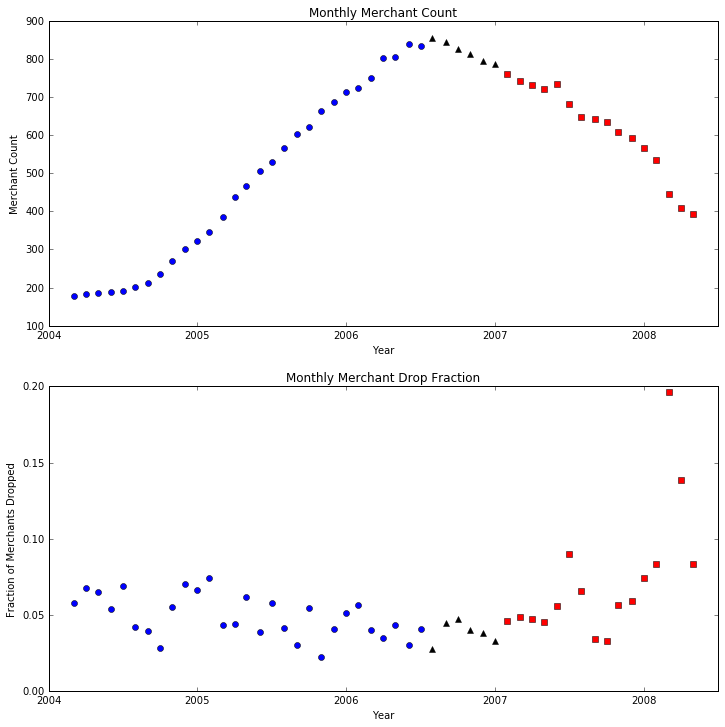

In [28]:
f, a1, a2, dat = makeStackedMerchantPlots(plots='both')

### Finally, Some Analysis!
The two simple plots above revealed an additional narrative to the story the president was telling during his examination.

1. Total merchant count was maximum on July 2006. In this month, the president stopped making required payments to the investors.
2. From February 2004 thru July 2006, it appears that monthly merchant drop rates as a fraction of merchant count in the prior month appeared to be trending downward. The variation in this rate of dropped merchants also appeared to be falling during this period.
3. A demand letter was issued to the president in January 2007, and the intial claim filed in February 2007. From this point forward, the merchant drop rate reversed its downward trend and began trending upward.

Since trend lines can be quantified by slopes of linear regression lines, lets compare the slopes of the first region defined by the blue points and the second region defined by all the red points.  Start with a quick derivation of the formula for the linear regression weights.

As has been derived in countless textbooks, the linear least squares equation for $\wv$ can be written in matrix form as

$\Xv^T \Xv \wv = \Xv^T \Tv$

Each row of $\Xv$ is a sample (51 in our case) and each column is a feature.  Even though we only have a single feature, we need an additional column of ones in $\Xv$ in order to compute both the slope $w_1$ and the intercept $w_0$.

There are several ways to solve for $\wv$, but the above form of the equation was chosen so that we can use the *lstsq* function because it does not assume linearly independent matrix columns. 

    w = np.linalg.lstsq(np.dot(X.T,X), np.dot(X.T, T))
    
$X$ is the *yearFrac* and $T$ is the *merchant_drop_rate* fields in our data frame. Before we can work with these as matrices, we need to convert these columns to numpy arrays, remove the first row because rate data starts in the second row, and append a columns of 1's to allow us to compute $w_0$

In [30]:
X = np.array(data['yearFrac'])[1:, np.newaxis]  # 1st row doesn't have rate info
T = np.array(data['merchant_drop_rate'])[1:, np.newaxis]
X1 = np.hstack((np.ones((len(X), 1)), X))  # N x 1 vector of 1's hstack with X
X1.shape, T.shape

((51, 2), (51, 1))

In [31]:
def makeStandardize(X):
    means = X.mean(axis=0)
    stds = X.std(axis=0)
    
    def standardize(origX):
        return (origX - means) / stds
    
    def unStandardize(stdX):
        return stds * stdX + means
    
    return (standardize, unStandardize)

def train(X, T):
    w = np.linalg.lstsq(np.dot(X.T,X), np.dot(X.T, T))
    return w[0]

def use(x, w):
    return np.dot(x, w)

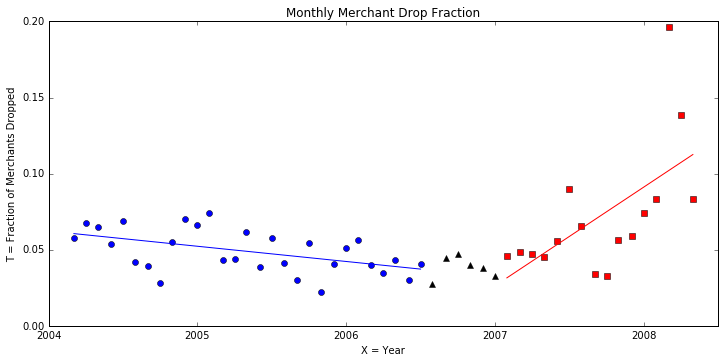

In [36]:
# add regression lines
pre_legal_weights = train(X1[0:29,:], T[0:29,:])  # w0 (intercept), w1 (slope)
post_legal_weights = train(X1[-16:,:], T[-16:,:])
pre_legal_regress = use(X1[0:29,:], pre_legal_weights)
post_legal_regress = use(X1[-16:,:], post_legal_weights)
d4 = np.vstack((pre_legal_regress, post_legal_regress))
f, a1, a2, data = makeStackedMerchantPlots(plots='bottom')
a2.set_xlabel("X = Year")
a2.set_ylabel("T = Fraction of Merchants Dropped")
plt.plot(data[0]['yearFrac'], d4[:29], 'b')
plt.plot(data[2]['yearFrac'], d4[-16:,:], 'r')

In the above chart, we are modeling the target T, **Faction of Merchants Dropped** as a function of X month in **Year**:

\begin{align*}
T(blue) = w_{0, blue} + w_{1, blue}X \\
T(red) = w_{0, red} + w_{1, red}X
\end{align*}

There are two things that jump out form the above chart: 1) the slopes of the blue and red regression lines and 2) the all those extreme red drop rate points.  The first observation can be summarized by asking: Are the slopes the same?  In other words, we want to test if:
\begin{align*}
H_0: w_{1, blue} = w_{1, red} \\
H_1: w_{1, blue} < w_{1, red}
\end{align*}

The first step is to compute the appropriate statistic [[7]](http://www.real-statistics.com/regression/hypothesis-testing-significance-regression-line-slope/comparing-slopes-two-independent-samples/):
\begin{align*}
t = \frac{w_{1, red} - w_{1, blue}}{\sqrt{s_{w_{1, red}}^2 + s_{w_{1, blue}}^2}}
\end{align*}

The terms in the denominator are variances of the red and blue line slopes respectively:
\begin{align*}
s_{w_{1, red}}^2 = \frac{s_{TX, red}^2}{s_{X, red}^2(n_{red}-1)} \\
s_{w_{1, blue}}^2 = \frac{s_{TX, blue}^2}{s_{X, blue}^2(n_{blue}-1)}
\end{align*}

where $s_{X}^2$ is the variance of the time (year) values and $s_{TX} = s_T \sqrt{(1-r^2)\frac{n-1}{n-2}}$ where $r^2$ is the *coefficient of determination* between $X$ and $T$ and $s_{T}$ is the standard deviation of the target values.  Each of these quantities need to be evaluated in each region (blue or red).

These calculations are performed in the **RegressionInference** module with the **compareTwoRegSlopes** function.  Because this function takes vectors for the independent (x) and dependent (y) variables implemented as numpy arrays, we need to wrap the pandas series objects with calls to **as_matrix** as shown below.

In [7]:
import RegressionInference as ri, numpy as np

slope_compare_test = ri.compareTwoRegSlopes(d1.as_matrix(['yearFrac']), d1.as_matrix(['merchant_drop_rate']),
                                            d3.as_matrix(['yearFrac']), d3.as_matrix(['merchant_drop_rate']),
                                            alpha=0.01, tail_type='left')

In [8]:
'{0:.5}'.format(slope_compare_test['p_val']), slope_compare_test['sig']

('0.0010597', True)

### Results & Conclusion
Even being conservative and setting the confidence level at 99% ($\alpha = 0.01$), we can still reject the null hypothesis in favor of the altenative.  There is about 0.1% probability that the blue and red slopes are the same.  Conversely, there is roughly a 99.9% chance that the red slope is larger than the blue slope.

From 2004 through 2007, merchant drops gradually decelerated, the variability in the drop rate fell, and the total merchant count was increasing.  A reasonable interpretation of these facts would be that the business had been maturing and doing well.  Then as soon as legal action commenced, the merchant drop rate climbed significantly and the merchant count fell.  If the business truely had problems, one would reasonalbly have expected merchants counts to fall and a flat or increasing drop rate **prior to** defaulting (not afterward).

Consistent with these findings are the extremely high red drop rate points

### Prologue
This analysis motivated the American group to file a fraudulant conveyance action against the Canadian company.  During the course of this action, additional information became available that allowed me to show that many of the dropped merchants in this analysis could be identified in other accounts which were not originally disclosed.  These **other accounts** were in the name of other companies and entities controlled by the president of the original company we sued.  This analysis and the additional findings caused the defendants to shift their arguments away from contesting that the transfer of merchants had occurred, towards one where they claimed that the amount of actual fraud was less than what the plaintiffs claimed.

The dispute over the quanta (the amount of actual fraud) was a much more extensive, but arguably not as interesting analysis involving the aggregation of large amounts of disparate data sources into a single comprehensive database from which the plaintiffs estimates were based.  When I met with the defendants expert witness to go over our analysis of the quanta, he found it robust and unassailable.  An agreeable settlement resulted within hours of this meeting.

### References
[1] Judgment: https://github.com/MichaelSzczepaniak/FraudulentConveyance/blob/master/Judgment%20%28redacted%29.pdf  
[2] Judgment Debtor Exam: https://www.attorneygeneral.jus.gov.on.ca/english/courts/guides/After_Judgement_Guide_to_Getting_Results_EN.html#_Toc436642217  
[3] What is Fraudulant Conveyance? https://en.wikipedia.org/wiki/Fraudulent_conveyance  
[4] Raw Data: https://github.com/MichaelSzczepaniak/FraudulentConveyance/raw/master/data/rawOsMerchantReportsTxt/raw_monthly_merchant_datat.zip  
[5] What is preprecessing? https://www.techopedia.com/definition/14650/data-preprocessing  
[6] Firefox SQLite Manager Add-on: https://addons.mozilla.org/en-US/firefox/addon/sqlite-manager/  
[7] Comparing the slopes for two independent samples: http://www.real-statistics.com/regression/hypothesis-testing-significance-regression-line-slope/comparing-slopes-two-independent-samples/    